In [1]:
import pytz
import os
import sqlite3
import re
import uproot
import IPython
import sys
import copy
import numpy as np
import pandas as pd
import pymap3d as pm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from pandasql import sqldf
from rnog_data.runtable import RunTable
from datetime import datetime, timedelta
from scipy.fft import fft
from scipy.signal import stft
from NuRadioReco.modules.io.RNO_G.readRNOGDataMattak import readRNOGData
from NuRadioReco.utilities import units
from Flight import Flight
from IPython.display import clear_output


pd.options.display.float_format = '{:20,.15f}'.format
#-------------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------
from FlightTracker import FlightTracker

current_month = '04'
next_month = '06'

start_time=f'2023-{current_month}-01 00:00:00'
stop_time=f'2023-{next_month}-01 00:00:00'

#start_time=f'2023-01-01 00:00:00'
#stop_time=f'2024-01-01 00:00:00'

tracker_initial = FlightTracker(start_time, stop_time, destination='./flights/flights_2023.db', already_calculated=True)
tracker = copy.deepcopy(tracker_initial) # make a new instance of the tracker
print(len(tracker.flights), len(tracker.flights_distinct))
tracker.flights_distinct

172826 1002


,index,flightnumber,date,filename,mintime,maxtime,min_r,min_z,theta
0,3261,DLH9922,2023-04-01,2023.04.01-051111.db,2023-04-01 00:42:32.100000,2023-04-01 01:01:07.500000,33.100000000000001,10.800000000000001,15.000000000000000
1,3262,N/A,2023-04-01,2023.04.01-051111.db,2023-04-01 00:59:37.100000,2023-04-01 03:40:13.900000,99.900000000000006,7.800000000000000,52.000000000000000
2,3263,N/A,2023-04-01,2023.04.01-051111.db,2023-04-01 05:21:28.400000,2023-04-01 18:48:53.900000,89.900000000000006,7.200000000000000,57.000000000000000
3,3264,CSN312,2023-04-01,2023.04.01-051111.db,2023-04-01 02:49:29.100000,2023-04-01 03:05:38.800000,72.799999999999997,7.700000000000000,49.000000000000000
4,3265,DLH491,2023-04-01,2023.04.01-051111.db,2023-04-01 03:20:48.200000,2023-04-01 03:40:39.000000,32.899999999999999,10.100000000000000,15.000000000000000
...,...,...,...,...,...,...,...,...,...
997,1703,AIC103,2023-05-31,2023.06.01-051619.db,2023-05-31 05:26:06.200000,2023-05-31 05:38:04.700000,122.799999999999997,10.400000000000000,54.000000000000000
998,1704,N/A,2023-05-31,2023.06.01-051619.db,2023-05-31 05:28:47.000000,2023-05-31 09:46:47.300000,77.200000000000003,8.800000000000001,67.000000000000000
999,1705,QTR65R,2023-05-31,2023.06.01-051619.db,2023-05-31 05:39:35.100000,2023-05-31 05:54:49.600000,72.299999999999997,8.300000000000001,6.000000000000000
1000,1706,UAE41P,2023-05-31,2023.06.01-051619.db,2023-05-31 06:37:17.000000,2023-05-31 06:52:21.400000,72.400000000000006,8.900000000000000,6.000000000000000


In [2]:
'''con = sqlite3.connect('./header_files_for_time_range/header_2023')

temp_df = pd.read_sql_query(f'Select * from all_triggers_2023_04 where lt_triggers = 1', con)

con.close()
print(len(temp_df))'''

temp_df = pd.DataFrame()
con = sqlite3.connect('./header_files_for_time_range/header_2023')
for table in ['all_triggers_2023_04', 'all_triggers_2023_05']:
    temp = pd.read_sql_query(f'Select * From {table}', con)
    if(len(temp_df == 0)):
        temp_df = temp
    else:
        temp_df = pd.concat([temp_df, temp], ignore_index=True, sort=False)
con.close()
temp_df

,index,station_number,run_number,event_number,trigger_time,radiant_triggers,lt_triggers,force_triggers
0,0,11,2084,7422,"1,682,928,352.212568283081055",1,0,0
1,1,11,2084,7423,"1,682,928,352.277557611465454",0,0,1
2,2,11,2084,7424,"1,682,928,352.545515298843384",1,0,0
3,3,11,2084,7425,"1,682,928,353.990741968154907",1,0,0
4,4,11,2084,7426,"1,682,928,354.940427780151367",1,0,0
...,...,...,...,...,...,...,...,...
9112751,9112751,24,1397,831,"1,685,526,800.990732908248901",0,1,0
9112752,9112752,24,1397,832,"1,685,526,801.763359308242798",0,1,0
9112753,9112753,24,1397,833,"1,685,526,802.987482786178589",0,1,0
9112754,9112754,24,1397,834,"1,685,526,803.648054599761963",0,1,0


In [3]:
# add fk_date_flightnumber
flights_distinct = tracker.flights_distinct
flights_distinct = sqldf(''' 
SELECT
    *
    ,date || '_' || flightnumber as fk_date_flightnumber
FROM flights_distinct
''')
flights = tracker.flights
flights = sqldf(''' 
SELECT
    *
    ,date(readtime) || '_' || flightnumber as fk_date_flightnumber
FROM flights
''')


flights_distinct['mintime'] = pd.to_datetime(flights_distinct.mintime).dt.tz_localize('UTC')
flights_distinct['maxtime'] = pd.to_datetime(flights_distinct.maxtime).dt.tz_localize('UTC')

flights_distinct['mintime_millis'] = flights_distinct.mintime.astype(np.int64) // 10 ** 6
flights_distinct['maxtime_millis'] = flights_distinct.maxtime.astype(np.int64) // 10 ** 6

flights_distinct['mintime_sec'] = flights_distinct.mintime.astype(np.int64) // 10 ** 9
flights_distinct['maxtime_sec'] = flights_distinct.maxtime.astype(np.int64) // 10 ** 9

flights_distinct['ID'] = flights_distinct.index

temp_df['trigger_time_millis'] = (temp_df['trigger_time'] * (10 ** 3)).astype(np.int64)
temp_df['trigger_time_sec'] = (temp_df['trigger_time']).astype(np.int64)

flights_distinct

,index,flightnumber,date,filename,mintime,maxtime,min_r,min_z,theta,fk_date_flightnumber,mintime_millis,maxtime_millis,mintime_sec,maxtime_sec,ID
0,3261,DLH9922,2023-04-01,2023.04.01-051111.db,2023-04-01 00:42:32.100000+00:00,2023-04-01 01:01:07.500000+00:00,33.100000000000001,10.800000000000001,15.000000000000000,2023-04-01_DLH9922,1680309752100,1680310867500,1680309752,1680310867,0
1,3262,N/A,2023-04-01,2023.04.01-051111.db,2023-04-01 00:59:37.100000+00:00,2023-04-01 03:40:13.900000+00:00,99.900000000000006,7.800000000000000,52.000000000000000,2023-04-01_N/A,1680310777100,1680320413900,1680310777,1680320413,1
2,3263,N/A,2023-04-01,2023.04.01-051111.db,2023-04-01 05:21:28.400000+00:00,2023-04-01 18:48:53.900000+00:00,89.900000000000006,7.200000000000000,57.000000000000000,2023-04-01_N/A,1680326488400,1680374933900,1680326488,1680374933,2
3,3264,CSN312,2023-04-01,2023.04.01-051111.db,2023-04-01 02:49:29.100000+00:00,2023-04-01 03:05:38.800000+00:00,72.799999999999997,7.700000000000000,49.000000000000000,2023-04-01_CSN312,1680317369100,1680318338800,1680317369,1680318338,3
4,3265,DLH491,2023-04-01,2023.04.01-051111.db,2023-04-01 03:20:48.200000+00:00,2023-04-01 03:40:39+00:00,32.899999999999999,10.100000000000000,15.000000000000000,2023-04-01_DLH491,1680319248200,1680320439000,1680319248,1680320439,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997,1703,AIC103,2023-05-31,2023.06.01-051619.db,2023-05-31 05:26:06.200000+00:00,2023-05-31 05:38:04.700000+00:00,122.799999999999997,10.400000000000000,54.000000000000000,2023-05-31_AIC103,1685510766200,1685511484700,1685510766,1685511484,997
998,1704,N/A,2023-05-31,2023.06.01-051619.db,2023-05-31 05:28:47+00:00,2023-05-31 09:46:47.300000+00:00,77.200000000000003,8.800000000000001,67.000000000000000,2023-05-31_N/A,1685510927000,1685526407300,1685510927,1685526407,998
999,1705,QTR65R,2023-05-31,2023.06.01-051619.db,2023-05-31 05:39:35.100000+00:00,2023-05-31 05:54:49.600000+00:00,72.299999999999997,8.300000000000001,6.000000000000000,2023-05-31_QTR65R,1685511575100,1685512489600,1685511575,1685512489,999
1000,1706,UAE41P,2023-05-31,2023.06.01-051619.db,2023-05-31 06:37:17+00:00,2023-05-31 06:52:21.400000+00:00,72.400000000000006,8.900000000000000,6.000000000000000,2023-05-31_UAE41P,1685515037000,1685515941400,1685515037,1685515941,1000


In [4]:
fk_timestamp = pd.DataFrame(columns = ['trigger_time_sec'], data = range(flights_distinct.mintime_millis.min() // 1000, flights_distinct.maxtime_millis.max() // 1000, 1))
fk_timestamp

,trigger_time_sec
0,1680309752
1,1680309753
2,1680309754
3,1680309755
4,1680309756
...,...
5217047,1685526799
5217048,1685526800
5217049,1685526801
5217050,1685526802


In [5]:
query = ''' 
SELECT
    count(trigger_time_sec) as sum_triggers_per_second
    --,station_number
    ,trigger_time_sec
    --,CASE 
    --    WHEN force_triggers = 1 THEN 1
    --    WHEN lt_triggers = 1 THEN 2
    --    WHEN radiant_triggers = 1 THEN 3
    --    ELSE -1
    --END AS trigger_type
    --,force_triggers
    --,lt_triggers
    --,radiant_triggers
    --,trigger_time_millis
FROM temp_df
--GROUP BY station_number, trigger_time_sec

GROUP BY trigger_time_sec
'''

test = sqldf(query)
test

,sum_triggers_per_second,trigger_time_sec
0,4,1682928352
1,2,1682928353
2,2,1682928354
3,2,1682928355
4,5,1682928356
...,...,...
1261562,3,1685526799
1261563,6,1685526800
1261564,2,1685526801
1261565,4,1685526802


In [6]:
fk_timestamp = fk_timestamp.merge(test, on=['trigger_time_sec'], how='left')

In [7]:
fk_timestamp

,trigger_time_sec,sum_triggers_per_second
0,1680309752,NaN
1,1680309753,NaN
2,1680309754,NaN
3,1680309755,NaN
4,1680309756,NaN
...,...,...
5217047,1685526799,3.000000000000000
5217048,1685526800,6.000000000000000
5217049,1685526801,2.000000000000000
5217050,1685526802,4.000000000000000


In [9]:
fk_timestamp.sum_triggers_per_second.fillna(0, inplace = True)
#fk_timestamp.station_number.fillna(-1, inplace=True)
#fk_timestamp.force_triggers.fillna(-1, inplace=True)

In [10]:
fk_timestamp

,trigger_time_sec,sum_triggers_per_second
0,1680309752,0.000000000000000
1,1680309753,0.000000000000000
2,1680309754,0.000000000000000
3,1680309755,0.000000000000000
4,1680309756,0.000000000000000
...,...,...
5217047,1685526799,3.000000000000000
5217048,1685526800,6.000000000000000
5217049,1685526801,2.000000000000000
5217050,1685526802,4.000000000000000


In [10]:
fk_timestamp['force_triggers'] = fk_timestamp.force_triggers.astype('int8')

In [11]:
fk_timestamp['station_number'] = fk_timestamp.station_number.astype('int8')

In [11]:
fk_timestamp['sum_triggers_per_second'] = fk_timestamp.sum_triggers_per_second.astype('uint16')

In [12]:
fk_timestamp.dtypes

trigger_time_sec            int64
sum_triggers_per_second    uint16
dtype: object

In [13]:
fk_timestamp

,trigger_time_sec,sum_triggers_per_second
0,1680309752,0
1,1680309753,0
2,1680309754,0
3,1680309755,0
4,1680309756,0
...,...,...
5217047,1685526799,3
5217048,1685526800,6
5217049,1685526801,2
5217050,1685526802,4


In [15]:
fk_timestamp[fk_timestamp.trigger_time_sec >= 1680338260].sort_values(by = ['trigger_time_sec'])

,trigger_time_sec,sum_triggers_per_second,station_number,force_triggers
28508,1680338260,6,21,0
28509,1680338261,0,-1,-1
28510,1680338262,0,-1,-1
28511,1680338263,3,21,0
28512,1680338264,3,21,0
...,...,...,...,...
2726182,1682878838,1,24,0
2726183,1682878839,2,11,0
2726184,1682878839,2,24,0
2726185,1682878840,1,13,0


In [16]:
fk_timestamp.force_triggers.unique()

array([-1,  0], dtype=int8)

In [17]:
flights_distinct.dtypes

index                                 int64
flightnumber                         object
date                                 object
filename                             object
mintime                 datetime64[ns, UTC]
maxtime                 datetime64[ns, UTC]
min_r                               float64
min_z                               float64
theta                               float64
fk_date_flightnumber                 object
mintime_millis                        int64
maxtime_millis                        int64
mintime_sec                           int64
maxtime_sec                           int64
ID                                    int64
dtype: object

In [18]:
fk_timestamp.sum_triggers_per_second.unique()

array([  0,   1,   2,   3,   6,   5,   7,   4,   9,  12,   8,  18,  21,
        56,  38,  40,  20,  10,  30,  22,  26,  15,  11,  16,  13,  34,
        28,  54,  24,  81,  78,  51,  29,  58,  57,  44, 100,  17,  23,
        60,  45,  62,  36,  52,  48,  50,  46,  32,  68,  66,  64,  70,
        14,  19,  33,  31,  25,  27,  35,  42,  76,  72,  39,  69,  63,
        90, 112,  74,  37,  96,  99,  75,  93, 102, 111,  84,  87, 105,
       117, 108,  92,  88,  80, 116, 145], dtype=uint16)

In [17]:
# join header information on flights_distinct
query = '''
SELECT 
    flightnumber
    ,fk_date_flightnumber
    --,station_number
    ,sum_triggers_per_second
    ,trigger_time_sec
FROM flights_distinct
LEFT JOIN ( 
            SELECT
                *
            FROM fk_timestamp
)t0

ON t0.trigger_time_sec > flights_distinct.mintime_sec
AND t0.trigger_time_sec < flights_distinct.maxtime_sec
WHERE trigger_time_sec is not null
and min_r < 50
--AND force_triggers = 0
--AND lt_triggers = 1
--AND radiant_triggers = 1
--GROUP BY fk_date_flightnumber, station_number, trigger_time_sec
GROUP BY fk_date_flightnumber, trigger_time_sec
'''

result = sqldf(query)
clear_output(wait=True)
result

,flightnumber,fk_date_flightnumber,sum_triggers_per_second,trigger_time_sec
0,CPA095,2023-04-01_CPA095,0,1680338251
1,CPA095,2023-04-01_CPA095,0,1680338252
2,CPA095,2023-04-01_CPA095,0,1680338253
3,CPA095,2023-04-01_CPA095,0,1680338254
4,CPA095,2023-04-01_CPA095,0,1680338255
...,...,...,...,...
839345,UAE93Q,2023-05-31_UAE93Q,3,1685511213
839346,UAE93Q,2023-05-31_UAE93Q,3,1685511214
839347,UAE93Q,2023-05-31_UAE93Q,12,1685511215
839348,UAE93Q,2023-05-31_UAE93Q,15,1685511216


In [18]:
result[result.flightnumber == 'CPA095  '].sort_values(by = ['trigger_time_sec'])

,flightnumber,fk_date_flightnumber,station_number,sum_triggers_per_second,trigger_time_sec
0,CPA095,2023-04-01_CPA095,21,6,1680338260
1,CPA095,2023-04-01_CPA095,21,3,1680338263
2,CPA095,2023-04-01_CPA095,21,3,1680338264
3,CPA095,2023-04-01_CPA095,21,3,1680338265
4,CPA095,2023-04-01_CPA095,21,3,1680338275
...,...,...,...,...,...
294,CPA095,2023-04-01_CPA095,21,3,1680339367
295,CPA095,2023-04-01_CPA095,21,3,1680339371
296,CPA095,2023-04-01_CPA095,21,3,1680339372
297,CPA095,2023-04-01_CPA095,21,3,1680339375


In [18]:
#-------------------------------------------------------------------------------------------------------------------
def part_lin(x, times, r):
    return_linspace = []
    for element in x:
        #print()
        #print(times, element)
        #print(np.where(times <= element))
        #print()
        index = np.where(times <= element)[0][-1]
        if index >= (len(times) - 1):
            index = index - 1
            print(f'Index {index} out of range {len(times) - 1}')
        y2 = r.iloc[index+1]
        y1 = r.iloc[index]
        x2 = times.iloc[index+1]
        x1 = times.iloc[index]
        m = (y2 - y1) / (x2 - x1)
        t = y2 - m * x2
        return_linspace.append(m*element+t)
    len_ret = len(return_linspace)
    len_x = len(x)
    while(len_ret < len_x):
        return_linspace.append(0)

    return return_linspace

In [19]:
result_df = pd.DataFrame()
length = len(flights_distinct)

for i in range(length):
    clear_output(wait=True)
    #----------------------------------------------------------
    fk_date_flightnumber = flights_distinct.fk_date_flightnumber.iloc[i]
    print(fk_date_flightnumber, ', ', i, ':', length)

    #----------------------------------------------------------   
    flights_temp = flights[flights.fk_date_flightnumber == fk_date_flightnumber]
    
    times = pd.to_datetime(flights_temp.readtime_utc, format='ISO8601').astype('int64') / 10**9
    r = np.sqrt(flights_temp.r2)
    trigger_times = result[result.fk_date_flightnumber == fk_date_flightnumber].trigger_time_sec

    if((len(trigger_times) == 0) | len(times) == 0):
        print('len trigger_times = 0 or flightnunber == N/A or len(times) == 0')
        continue
    
    temp_table = pd.DataFrame(result[result.fk_date_flightnumber == fk_date_flightnumber].copy())
    print(f'flightnumber: {fk_date_flightnumber}')

    #print('--------------------------------------------')
    #print(times.min(), '<', trigger_times.min())
    #print(trigger_times.max(), '<', times.max())
    #print('--------------------------------------------')

    temp_table['d'] = part_lin(trigger_times, times, r)
    if(len(temp_table)):
        result_df = pd.concat([result_df, temp_table], ignore_index=True, sort=False)

result_df = result_df[~result_df['flightnumber'].str.contains('SKI', na=False)]
result_df


2023-05-31_AIC187   ,  1001 : 1002
flightnumber: 2023-05-31_AIC187  


,flightnumber,fk_date_flightnumber,sum_triggers_per_second,trigger_time_sec,d
0,DLH9922,2023-04-01_DLH9922,0,1680309753,149.482938468456268
1,DLH9922,2023-04-01_DLH9922,0,1680309754,149.234492778778076
2,DLH9922,2023-04-01_DLH9922,0,1680309755,148.986047148704529
3,DLH9922,2023-04-01_DLH9922,0,1680309756,148.737601459026337
4,DLH9922,2023-04-01_DLH9922,0,1680309757,148.489155769348145
...,...,...,...,...,...
1278251,UAE93Q,2023-05-31_UAE93Q,3,1685511213,143.552009858635415
1278252,UAE93Q,2023-05-31_UAE93Q,3,1685511214,143.552009858635415
1278253,UAE93Q,2023-05-31_UAE93Q,12,1685511215,143.552009858635415
1278254,UAE93Q,2023-05-31_UAE93Q,15,1685511216,143.552009858635415


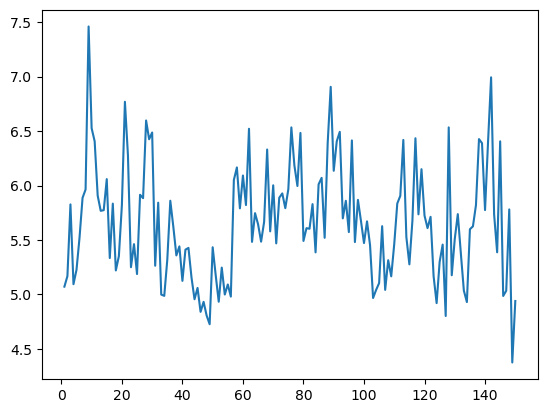

In [21]:
test = sqldf('Select avg(sum_triggers_per_second) as avg_triggers_per_sec, round(d, 0) as d from result_df group by round(d, 0)')
plt.plot(test.d, test.avg_triggers_per_sec)

In [25]:
sqldf('Select count(d), d from result_df group by d')

,count(d),d
0,2833,0.000000000000000
1,9901,1.000000000000000
2,11352,2.000000000000000
3,7938,3.000000000000000
4,1547,4.000000000000000
...,...,...
145,1974,145.000000000000000
146,1384,146.000000000000000
147,867,147.000000000000000
148,568,148.000000000000000


In [16]:
test

,avg_triggers_per_sec,d
0,2.38,0.53
1,2.00,0.53
2,2.00,0.54
3,2.00,0.54
4,2.00,0.54
...,...,...
241690,6.00,149.89
241691,3.00,149.89
241692,3.00,149.90
241693,2.00,149.92


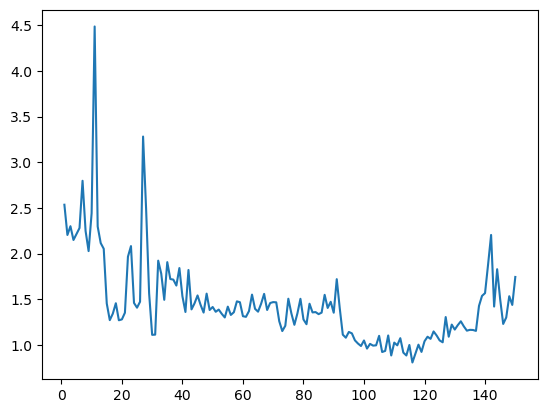

In [28]:
plt.plot(test.d, test.avg_triggers_per_sec)

Text(0, 0.5, '# triggers [Hz]')

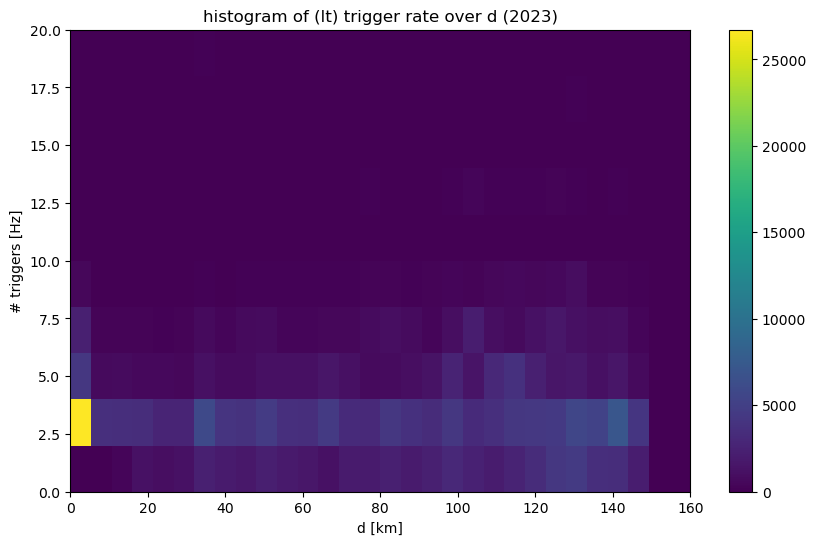

In [28]:
from matplotlib.colors import LogNorm
#result_df = result_df[~result_df['flightnumber'].str.contains('SKI', na=False)]
max_index = result_df['triggers_per_second'].idxmax()

plt.figure(figsize=(10, 6))
# Get the flightnumber at this index
#max_flightnumber = result_df.at[max_index, 'flightnumber']
#print(max_flightnumber)
#h, xedges, yedges, image = plt.hist2d(result_df.d, result_df.triggers_per_second, range = [[0, 160], [0, 15]], bins = [100, 10])
h, xedges, yedges, image = plt.hist2d(result_df.d, result_df.triggers_per_second, range = [[0, 160], [0,20]], bins = [30, 10])#, range = [[0, 160], [0, 15]], bins = [100, 15])#, norm = LogNorm())
plt.colorbar()
#plt.semilogy()
plt.title('histogram of (lt) trigger rate over d (2023)')
plt.xlabel('d [km]')
plt.ylabel(f'# triggers [Hz]')
#plt.savefig('./saved_figures/hist2d_lt_triggers_per_sec_over_d_2023.pdf')

Text(0, 0.5, '# counts')

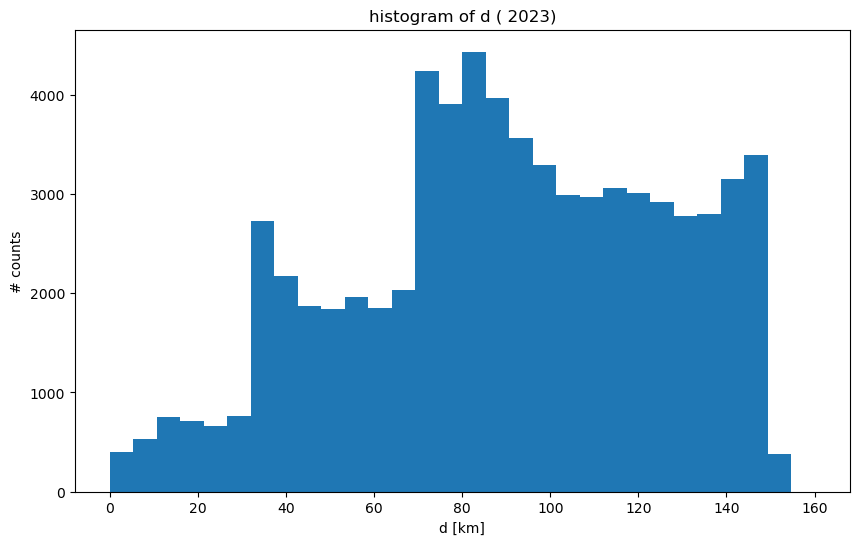

In [29]:
plt.figure(figsize=(10, 6))
a = plt.hist(np.sqrt(flights.r2), bins = xedges)

plt.title('histogram of d ( 2023)')
plt.xlabel('d [km]')
plt.ylabel(f'# counts')
#plt.savefig('./saved_figures/hist_d_2023.pdf')

/tmp/ipykernel_6829/2947665761.py:2: RuntimeWarning: invalid value encountered in divide
  plt.pcolormesh(xedges, yedges, h.T/a[0])


Text(0, 0.5, '# triggers [Hz]')

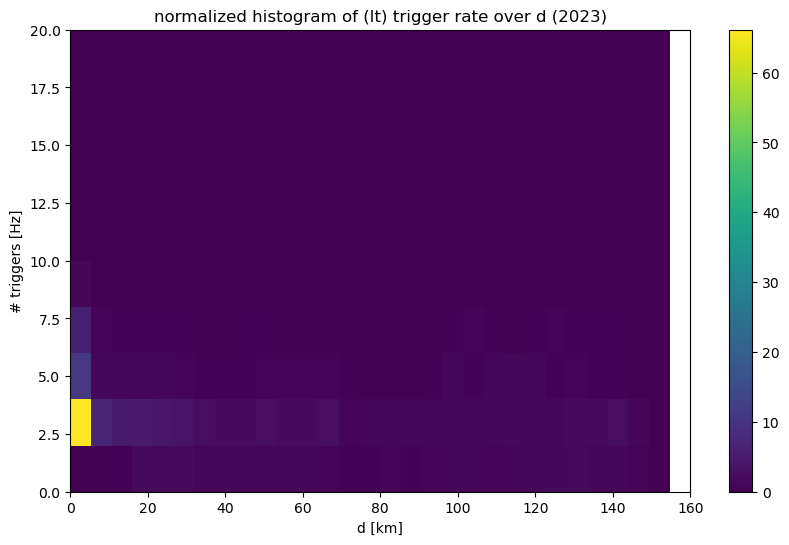

In [30]:
plt.figure(figsize=(10, 6))
plt.pcolormesh(xedges, yedges, h.T/a[0])
plt.colorbar()
plt.title('normalized histogram of (lt) trigger rate over d (2023)')
plt.xlabel('d [km]')
plt.ylabel(f'# triggers [Hz]')
#plt.savefig('./saved_figures/hist2d_lt_triggers_per_sec_over_d_NORMALIZED_2023_0.pdf')

In [7]:
pd.options.display.float_format = '{:20,.2f}'.format

In [7]:
temp_df.trigger_time_millis

0          1682928357386
1          1682928369010
2          1682928369503
3          1682928371716
4          1682928374912
               ...      
4856104    1685526800990
4856105    1685526801763
4856106    1685526802987
4856107    1685526803648
4856108    1685526803869
Name: trigger_time_millis, Length: 4856109, dtype: int64

In [9]:
flights_distinct.mintime_stamp

0      1682971758100
1      1682929487600
2      1682938024100
3      1682938787800
4      1682941053800
           ...      
603    1685511484700
604    1685526407300
605    1685512489600
606    1685515941400
607    1685526804200
Name: mintime_stamp, Length: 608, dtype: int64